<a href="https://colab.research.google.com/github/smagara/LangGraph-Coursework/blob/main/langgraph_RAG_agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

🛠️ LangGraph course assignment: Retriever agent for RAG
  - 1. Load a PDF document describing stock market activity for 2024
  - 2. Create a embeddings database from this for RAG retrieval
  - 3. Create a tool to search the embeddings
  - 4. Respond to user inquiries using the 2024 PDF data

  - Part of the freeCodeCamp course [here](https://www.youtube.com/watch?v=jGg_1h0qzaM)

  - Flow
    - START
    - LLM
    - retriever_agent (True)
    - END (False)


In [1]:
## installs
%pip install -U langgraph
%pip install -U langchain-openai
%pip install -U langchain-community
%pip install -U langchain-chroma
%pip install python-dotenv
%pip install pypdf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.7/143.7 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.5/216.5 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.4/70.4 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 1.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.5/19.5 MB 89.3 MB/s eta 0:00:0

In [2]:
## Setup imports
from typing import TypedDict, Annotated, Sequence
from dotenv import load_dotenv # to fetch OpenAI key from keyvault
from google.colab import userdata # to fetch OpenAI key from keyvault
from IPython.display import Image, display # to render the mermaid diagram of our Graph

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_chroma import Chroma
from langchain_core.messages import BaseMessage, ToolMessage, SystemMessage, HumanMessage, AIMessage
from langchain_core.tools import tool


In [3]:
## Integrate an AI LLM
load_dotenv()
openAIkey = userdata.get('OPENAI_API_KEY')
llm = ChatOpenAI(model_name="gpt-4o", temperature=0, openai_api_key=openAIkey) # temp 0 is more deterministic than stochastic

In [4]:
## Embedding Model - has to be compatible with the LLM
embeddings = OpenAIEmbeddings(model="text-embedding-3-small", openai_api_key=openAIkey)

In [6]:
## PDF
import os # Import the os module

pdf_path = "sample_data/Stock_Market_Performance_2024.pdf"
if not os.path.exists(pdf_path):
  raise FileNotFoundError(f"PDF not found at {pdf_path}")

pdf_loader = PyPDFLoader(pdf_path)

try:
  pages = pdf_loader.load()
  print(f"Loaded {len(pages)} pages from {pdf_path}")
except Exception as e:
  print(f"Error loading PDF: {e}")
  raise

## Chunking Process, ensure chunks overlap
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)

pages_split = text_splitter.split_documents(pages)

Loaded 9 pages from sample_data/Stock_Market_Performance_2024.pdf


In [7]:
## Create our vector store for RAG
persist_directory = "sample_data/persist"
collection_name = "Stock_Market_Perf"

if not os.path.exists(persist_directory):
  os.makedirs(persist_directory)

try:
  vectorstore = Chroma.from_documents(documents=pages_split,
                                      embedding=embeddings,
                                      persist_directory=persist_directory,
                                      collection_name=collection_name)
  print(f"Vectorstore created and saved to {persist_directory}")
except Exception as e:
  print(f"Error creating vectorstore: {e}")
  raise

Vectorstore created and saved to sample_data/persist


In [8]:
## Create our RAG Retriever
retriever = vectorstore.as_retriever(
    search_type="similarity",
    search_kwargs={"k": 5}) # K is the number of chunks to return

In [9]:
## Tools
@tool
def retriever_tool(query: str) -> str:
  """This tool searches and returns the info from the stock market 2024 PDF"""
  docs = retriever.invoke(query)

  if not docs:
    return "I found no relevant info in the 2024 stock market performance PDF"

  results = []
  for i, doc in enumerate(docs):
    results.append(f"Document {i+1}:\nContent: {doc.page_content}")
  return "\n\n".join(results)

tools = [retriever_tool]
llm = llm.bind_tools(tools)

In [10]:
## AgentState for LangGraph
class AgentState(TypedDict):
  messages: Annotated[Sequence[BaseMessage], add_messages] # use lang appender utility

In [11]:
def should_continue(state: AgentState):
  """Check if the last message contains tool calls"""
  result = state["messages"][-1]
  return hasattr(result, "tool_calls") and len(result.tool_calls) > 0


In [12]:
## Minimize halucinations
system_prompt = """
You are an intelligent AI assistant who answers questions about Stock Market Performance in 2024 based on the PDF document loaded into your knowledge base.
Use the retriever tool available to answer questions about the stock market performance data. You can make multiple calls if needed.
If you need to look up some information before asking a follow up question, you are allowed to do that!
Please always cite the specific parts of the documents you use in your answers.
"""

In [17]:
tools_dict = {our_tool.name: our_tool for our_tool in tools} # Creating a dictionary of our tools

In [13]:
## LLM Agent
def call_llm(state: AgentState) -> AgentState:
  """Function to call the LLM with the current state"""
  messages = list(state["messages"])
  messages = [SystemMessage(content=system_prompt)] + messages
  message = llm.invoke(messages)
  return {"messages": [message]}

# Retriever Agent
def take_action(state: AgentState) -> AgentState:
    """Execute tool calls from the LLM's response."""
    print(f"\nTaking action on RAG.")
    tool_calls = state['messages'][-1].tool_calls
    results = []
    for t in tool_calls:
        print(f"Calling Tool: {t['name']} with query: {t['args'].get('query', 'No query provided')}")

        if not t['name'] in tools_dict: # Checks if a valid tool is present
            print(f"\nTool: {t['name']} does not exist.")
            result = "Incorrect Tool Name, Please Retry and Select tool from List of Available tools."

        else:
            result = tools_dict[t['name']].invoke(t['args'].get('query', ''))
            print(f"Result length: {len(str(result))}")


        # Appends the Tool Message
        results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))

    print("Tools Execution Complete. Back to the model!")
    return {'messages': results}



In [14]:
graph = StateGraph(AgentState)
graph.add_node("llm", call_llm)
graph.add_node("retriever_agent", take_action)

graph.add_conditional_edges(
    "llm",
    should_continue,
    {
        True: "retriever_agent",
        False: END
    }
)

graph.add_edge("retriever_agent", "llm")
graph.set_entry_point("llm")

rag_agent = graph.compile()


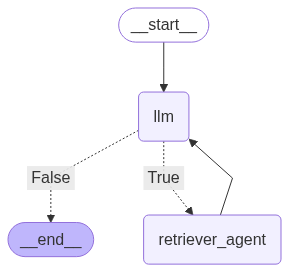

In [15]:
## draw our mermaid chart of the LangGraph flow
display(Image(rag_agent.get_graph().draw_mermaid_png()))

In [18]:
def running_agent():
    print("\n=== RAG AGENT===")

    while True:
        user_input = input("\nWhat is your question: ")
        if user_input.lower() in ['exit', 'quit']:
            break

        messages = [HumanMessage(content=user_input)] # converts back to a HumanMessage type

        result = rag_agent.invoke({"messages": messages})

        print("\n=== ANSWER ===")
        print(result['messages'][-1].content)

running_agent()


=== RAG AGENT===

Taking action on RAG.
Calling Tool: retriever_tool with query: Russell 2024 performance
Result length: 4360
Tools Execution Complete. Back to the model!

=== ANSWER ===
In 2024, the Russell 2000, which is a benchmark for small-cap stocks, experienced a more modest performance compared to larger indices. It rose about 10-11% for the year. This performance was in contrast to the broader market, where indices like the S&P 500 and the Nasdaq Composite saw much higher gains, with the S&P 500 delivering a roughly 25% total return and the Nasdaq Composite jumping nearly 29% for the year. The disparity highlighted that the rally in 2024 was not evenly distributed across the market, with mega-cap technology stocks dominating the gains. (Source: Document 1)

Taking action on RAG.
Calling Tool: retriever_tool with query: OpenAI stock performance 2024
Result length: 4863
Tools Execution Complete. Back to the model!

=== ANSWER ===
The documents do not provide specific informatio